In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.utils.multiclass import unique_labels
# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore')


# 準備

In [91]:
# データの読み込み
train_test_data = pd.read_csv('../train_test_2023.csv', encoding='ISO-8859-1')
submit_data = pd.read_csv('../submit_2023.csv', encoding='ISO-8859-1')
# 提出用にsubmit_dataをコピー
submit_data_copy = submit_data.copy()


In [92]:
train_test_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,68,State-gov,99106,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,20,United-States,no
1,22,State-gov,181096,Bachelors,13,Never-married,Prof-specialty,Own-child,Black,Male,0,0,20,United-States,no
2,42,Private,219155,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,yes
3,34,Private,443546,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,Germany,no
4,54,Private,199392,5th-6th,3,Divorced,Machine-op-inspct,Other-relative,White,Female,0,0,40,Nicaragua,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,Private,350850,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,yes
9996,59,Private,193375,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,10,United-States,no
9997,39,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999,0,40,United-States,yes
9998,18,Private,170094,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Female,0,0,20,United-States,no


In [93]:
submit_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y (yes or no),probability of yes (or score)
0,37,Private,162322,Assoc-voc,11,Separated,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,no,0.041282
1,46,Private,129007,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,41,United-States,no,0.349041
2,44,Private,76487,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,no,0.307653
3,47,Private,32825,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,yes,0.516912
4,33,Private,202191,Some-college,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,no,0.009758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,Private,157887,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,50,United-States,no,0.112914
996,31,Private,247328,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,30,El-Salvador,no,0.004698
997,38,Private,415578,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,no,0.131173
998,25,Local-gov,306352,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,40,Mexico,yes,0.553505


# EDA

## 欠損値
欠損値なし

In [94]:
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   workclass       10000 non-null  object
 2   fnlwgt          10000 non-null  int64 
 3   education       10000 non-null  object
 4   education-num   10000 non-null  int64 
 5   marital-status  10000 non-null  object
 6   occupation      10000 non-null  object
 7   relationship    10000 non-null  object
 8   race            10000 non-null  object
 9   sex             10000 non-null  object
 10  capital-gain    10000 non-null  int64 
 11  capital-loss    10000 non-null  int64 
 12  hours-per-week  10000 non-null  int64 
 13  native-country  10000 non-null  object
 14  y               10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [95]:
submit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   workclass                      1000 non-null   object 
 2   fnlwgt                         1000 non-null   int64  
 3   education                      1000 non-null   object 
 4   education-num                  1000 non-null   int64  
 5   marital-status                 1000 non-null   object 
 6   occupation                     1000 non-null   object 
 7   relationship                   1000 non-null   object 
 8   race                           1000 non-null   object 
 9   sex                            1000 non-null   object 
 10  capital-gain                   1000 non-null   int64  
 11  capital-loss                   1000 non-null   int64  
 12  hours-per-week                 1000 non-null   in

## 基礎統計量
capital-gainに外れ値99999あり

In [96]:
train_test_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.78340,1.901190e+05,10.090600,1138.299900,87.551600,40.967000
std,13.38485,1.064547e+05,2.563718,7908.032362,403.401171,12.036943
min,17.00000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.169925e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.783375e+05,10.000000,0.000000,0.000000,40.000000
75%,48.00000,2.397855e+05,13.000000,0.000000,0.000000,45.000000
max,90.00000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [97]:
submit_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,probability of yes (or score)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,37.974000,188020.652000,10.177000,815.688000,101.015000,41.04800,0.245855
std,13.047895,100173.088183,2.472607,4294.370703,439.813655,11.69626,0.305737
min,17.000000,19447.000000,1.000000,0.000000,0.000000,1.00000,0.000063
25%,27.000000,117399.250000,9.000000,0.000000,0.000000,40.00000,0.013127
50%,37.000000,177279.000000,10.000000,0.000000,0.000000,40.00000,0.086874
75%,46.250000,237017.500000,13.000000,0.000000,0.000000,45.00000,0.413868
max,81.000000,618130.000000,16.000000,99999.000000,3175.000000,99.00000,0.999766


## 量的変数の分布を確認
量的変数はtrain_test_dataとsubmit_dataで分布が大体同じだと確認できた  
→単純にtrain_test_dataのテストデータをランダムに分割して生成し、テストデータの精度を高めれば良さそう

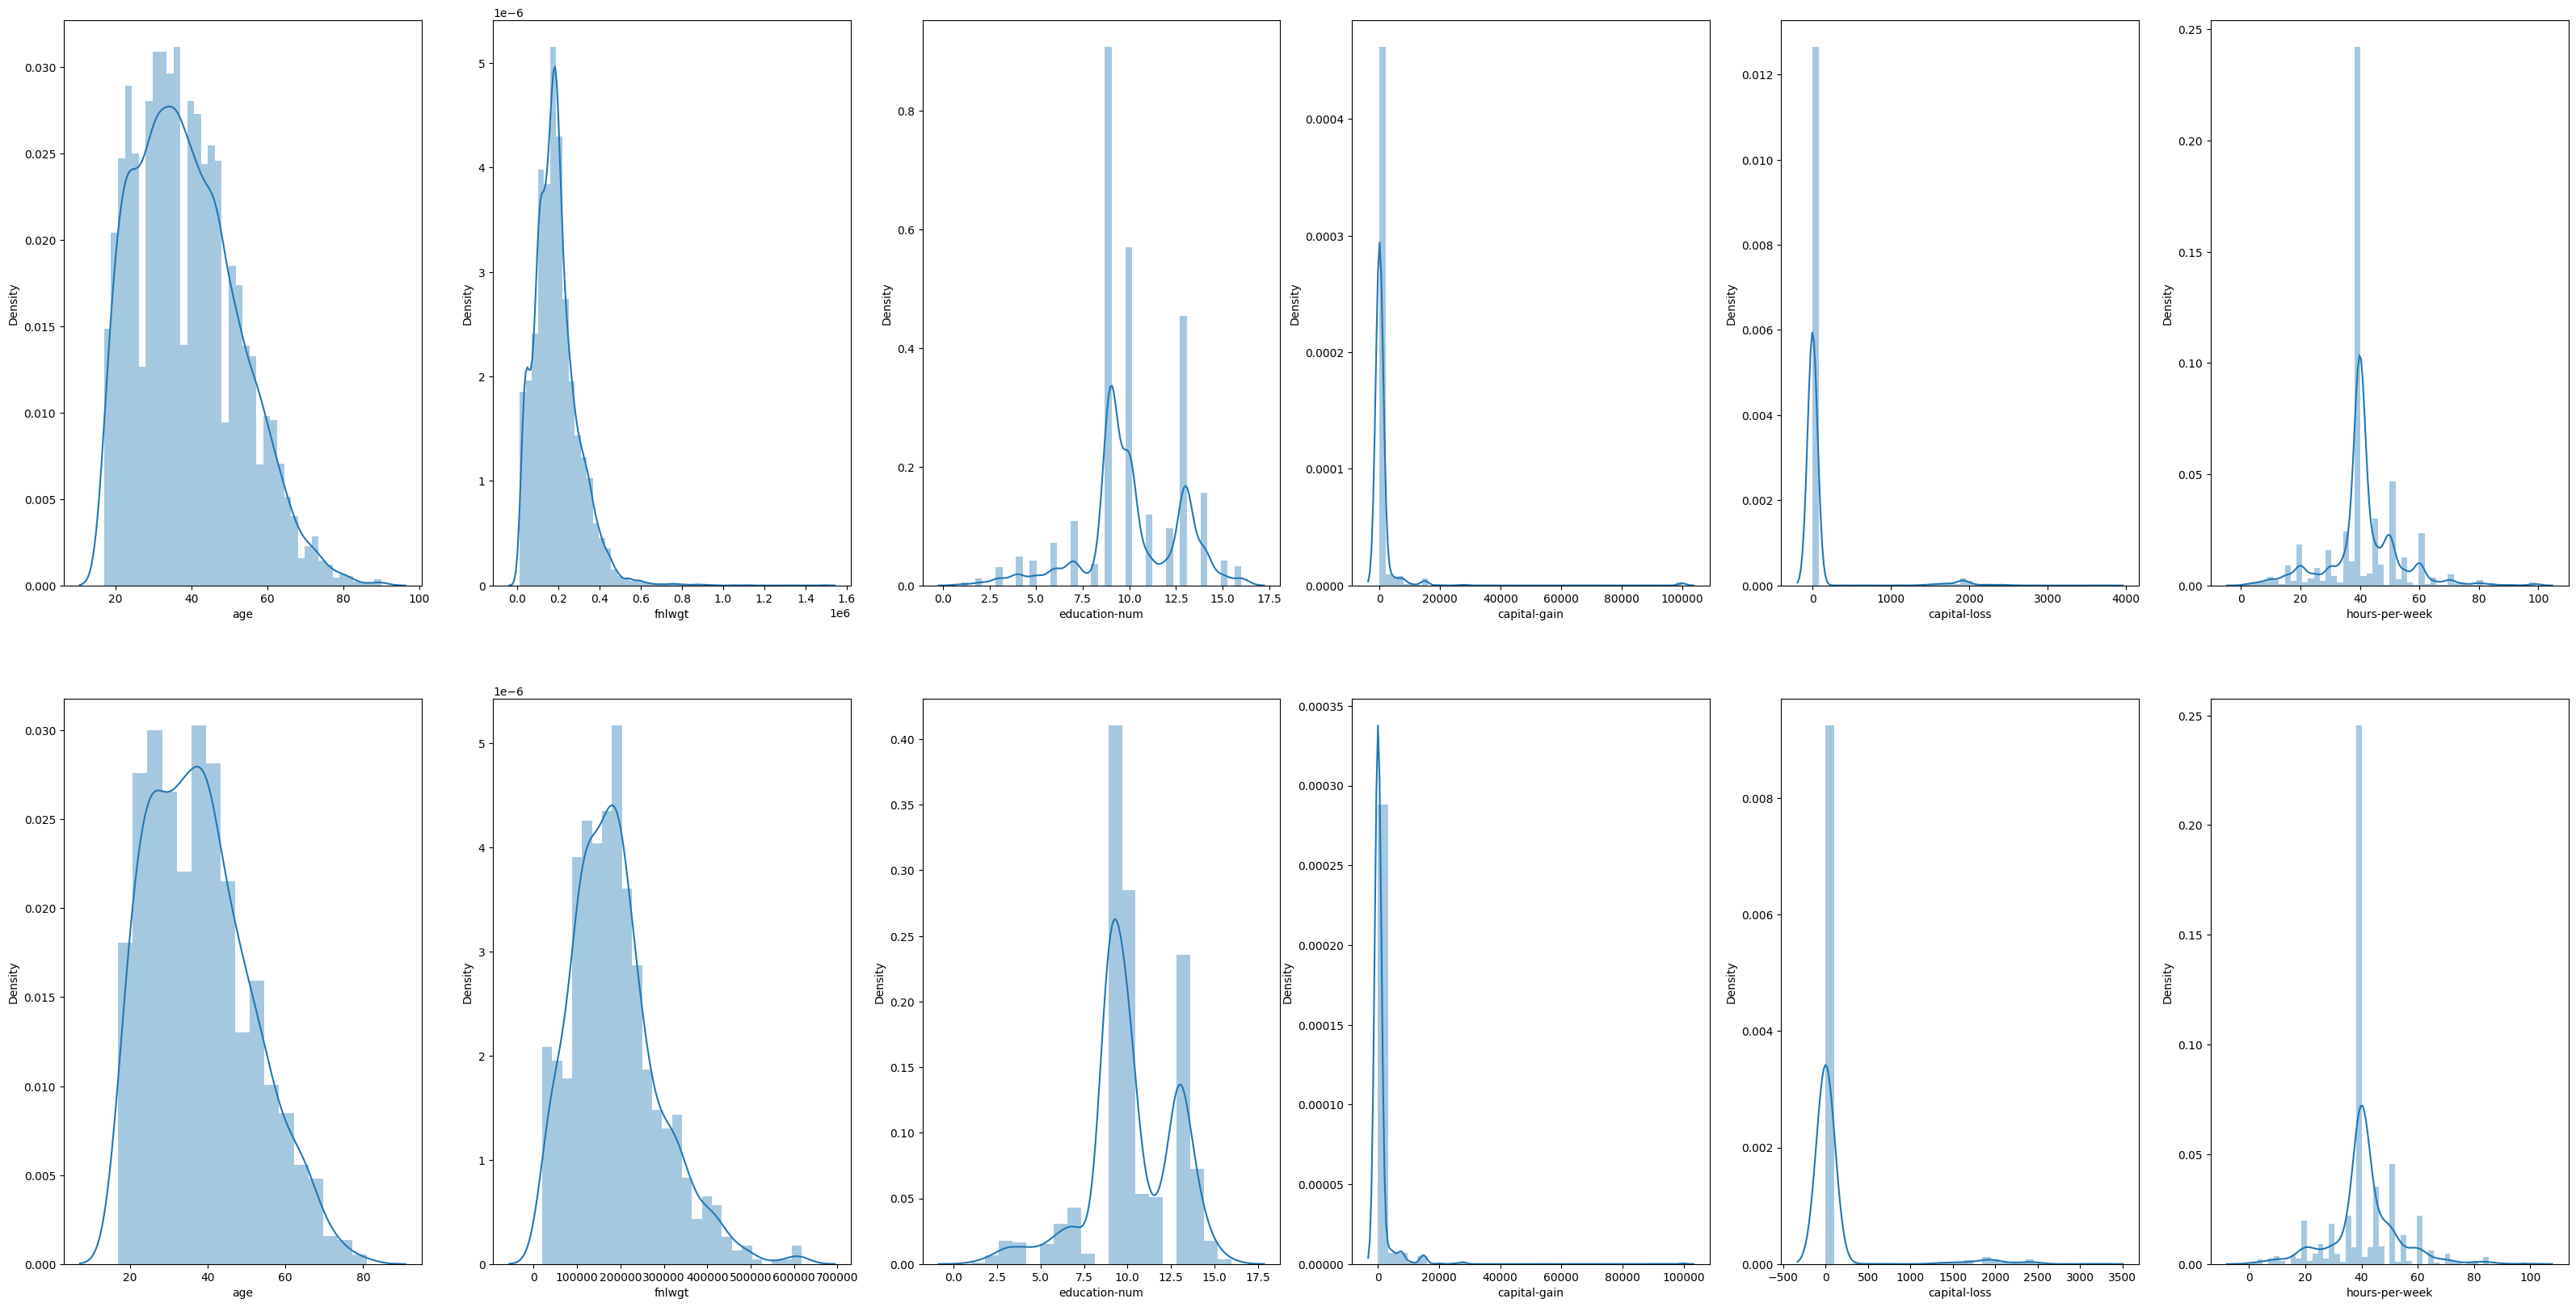

In [98]:
fig, axs = plt.subplots(2, 6, figsize=(40, 20))

# train_dataのヒストグラムとsubmit_dataのヒストグラムを比較
# train_test_dataのヒストグラムを縦に並べ、その隣の列にsubmit_dataのヒストグラムを縦に並べる
# 量的変数のヒストグラムを描画
# 量的変数のリストを作成
quantitative_variables = train_test_data.describe().columns
for i, col in enumerate(quantitative_variables):
    sns.distplot(train_test_data[col], ax=axs[0][i])
    sns.distplot(submit_data[col], ax=axs[1][i])

plt.show()

## 質的変数の分布を確認
質的変数はtrain_test_dataとsubmit_dataで分布が大体同じだと確認できた  
→単純にtrain_test_dataのテストデータをランダムに分割して生成し、テストデータの精度を高めれば良さそう

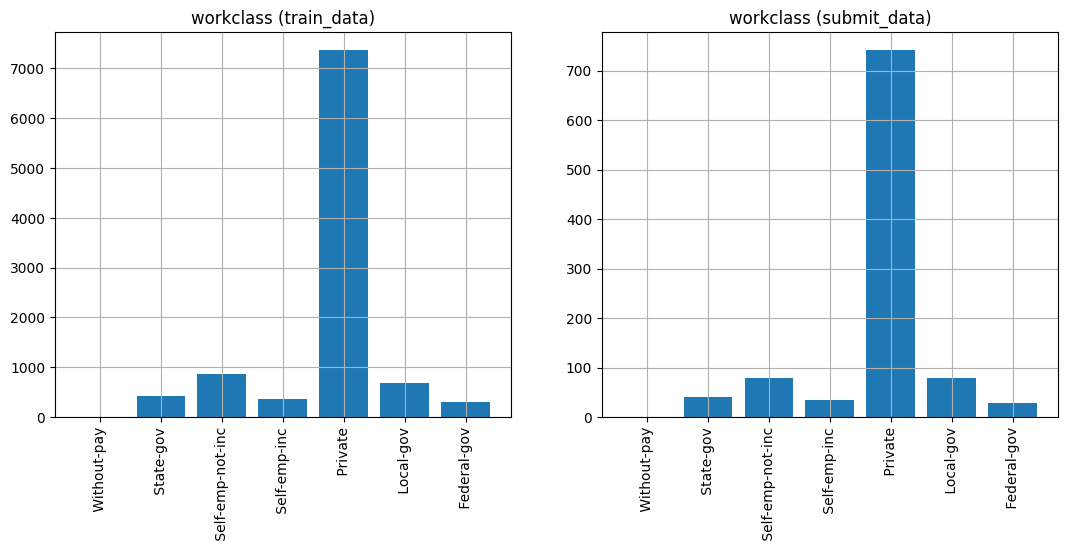

,train_data,submit_data
workclass,,
Without-pay,7,0.0
State-gov,425,41.0
Self-emp-not-inc,868,78.0
Self-emp-inc,364,34.0
Private,7358,741.0
Local-gov,678,78.0
Federal-gov,300,28.0


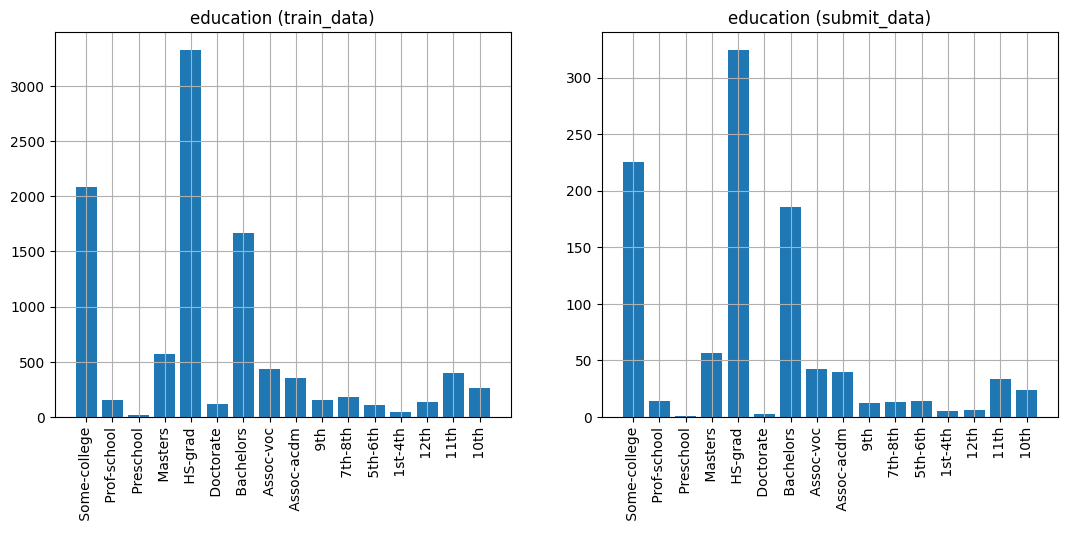

,train_data,submit_data
education,,
Some-college,2085,225
Prof-school,154,14
Preschool,19,1
Masters,572,57
HS-grad,3322,324
Doctorate,116,3
Bachelors,1665,186
Assoc-voc,435,42
Assoc-acdm,351,40


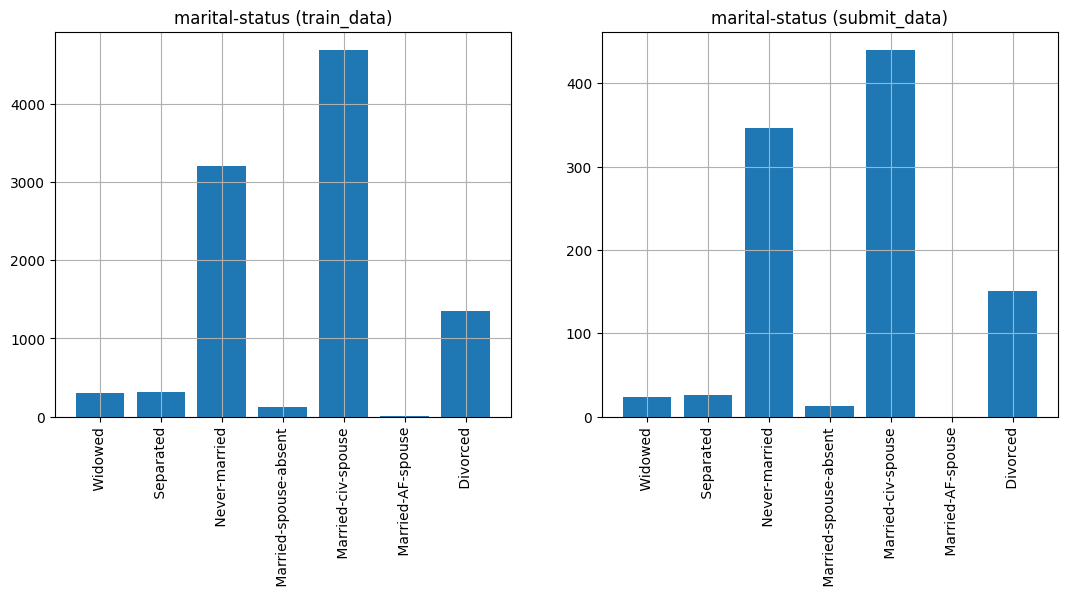

,train_data,submit_data
marital-status,,
Widowed,310,24.0
Separated,321,26.0
Never-married,3204,346.0
Married-spouse-absent,124,13.0
Married-civ-spouse,4683,440.0
Married-AF-spouse,9,0.0
Divorced,1349,151.0


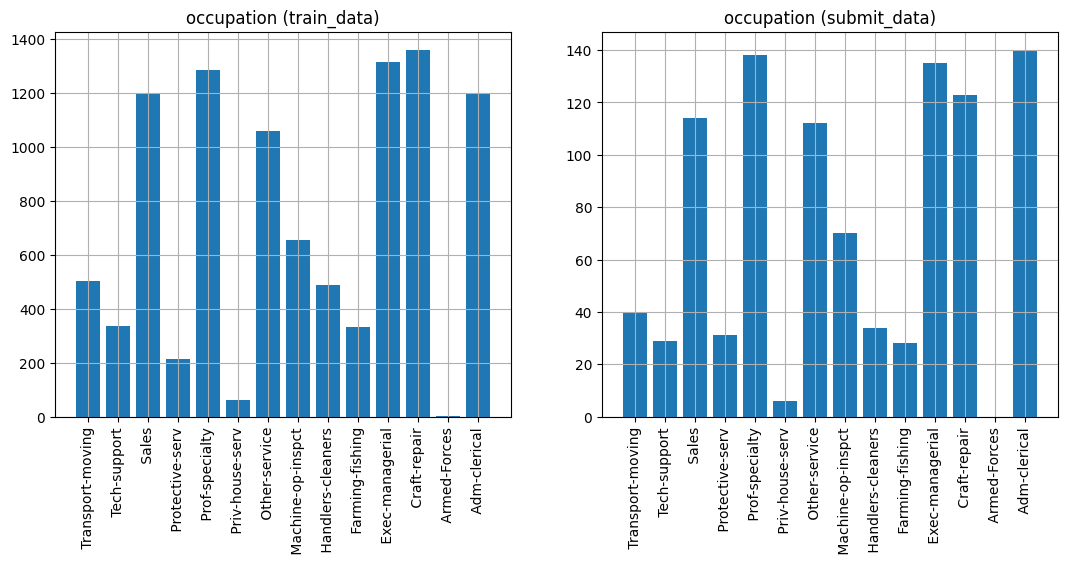

,train_data,submit_data
occupation,,
Transport-moving,504,40.0
Tech-support,335,29.0
Sales,1198,114.0
Protective-serv,215,31.0
Prof-specialty,1285,138.0
Priv-house-serv,60,6.0
Other-service,1057,112.0
Machine-op-inspct,656,70.0
Handlers-cleaners,487,34.0


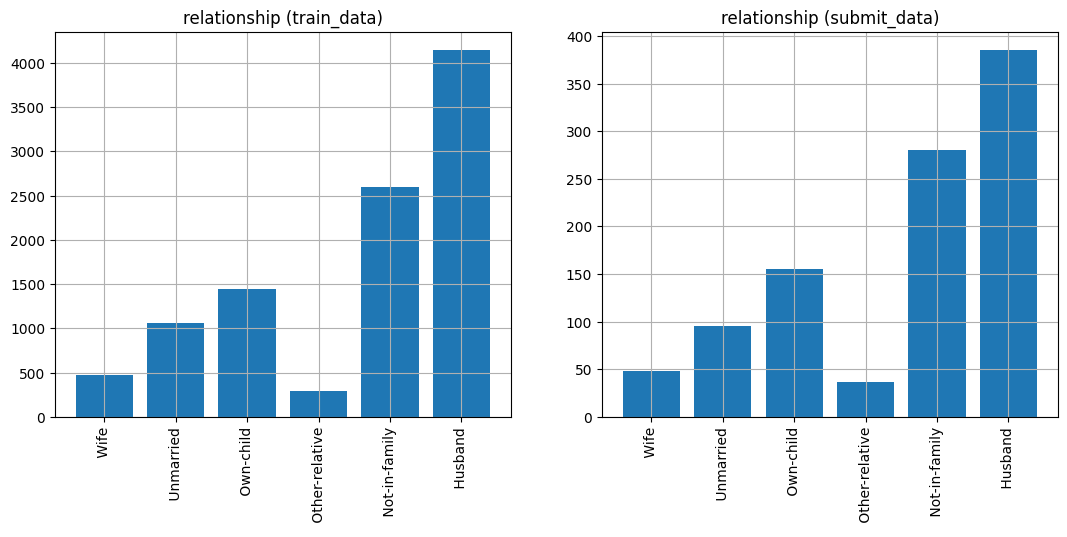

,train_data,submit_data
relationship,,
Wife,470,48
Unmarried,1057,95
Own-child,1442,155
Other-relative,292,37
Not-in-family,2597,280
Husband,4142,385


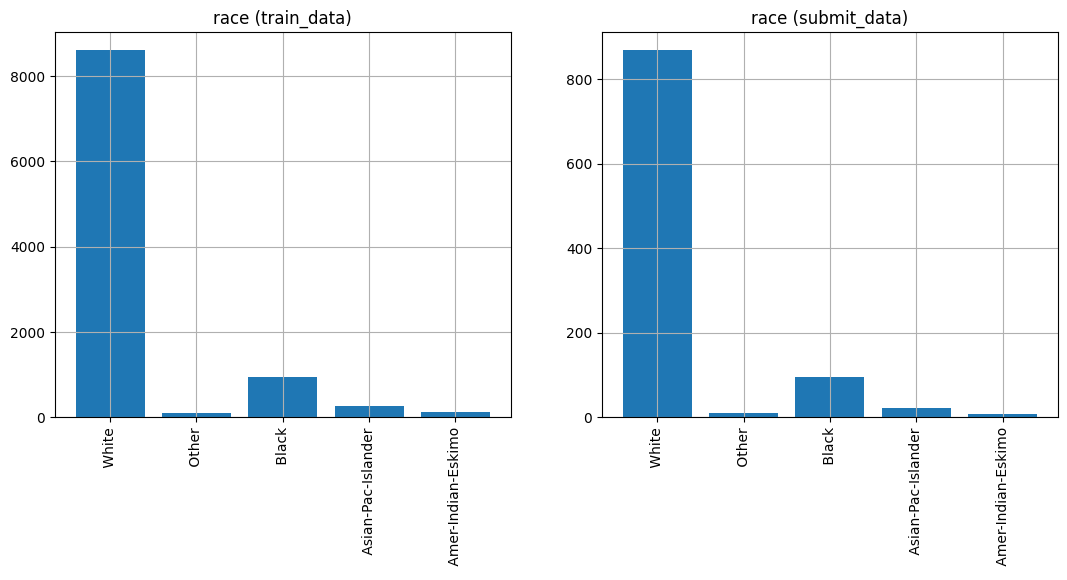

,train_data,submit_data
race,,
White,8608,868
Other,85,9
Black,940,94
Asian-Pac-Islander,253,22
Amer-Indian-Eskimo,114,7


KeyboardInterrupt: 

In [99]:
# カテゴリ変数のリストを作成
categorical_variables = train_test_data.describe(include='O').columns
# categorical_variablesからyを除外
categorical_variables = categorical_variables.drop('y')

# カテゴリ変数を引数に、そのカテゴリ変数の度数分布表を作成する関数を定義。データフレームでtrain_data, test_data, submit_dataの3つについて度数分布表を返す
def create_frequency_table(categorical_variables):
    for i, col in enumerate(categorical_variables):
        df = pd.DataFrame(train_test_data[col].value_counts()).sort_values(col, ascending=False)
        df.columns = ['train_data']
        df.fillna(0, inplace=True)
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.title(f'{col} (train_data)')
        plt.bar(df.index, df['train_data'])
        plt.xticks(rotation=90)
        plt.grid(True)

        # submit_dataの度数分布表を作成
        df['submit_data'] = submit_data[col].value_counts()
        df.fillna(0, inplace=True)
        plt.subplot(1, 3, 2)
        plt.title(f'{col} (submit_data)')
        plt.bar(df.index, df['submit_data'])
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.show()
        display(df)
        

create_frequency_table(categorical_variables)

## 目的変数について
yesが25%、noが75%ほどの不均衡データ

In [ ]:
df = pd.DataFrame(train_test_data['y'].value_counts()).sort_values('y', ascending=False)
df

,count
y,
yes,2448
no,7552


<Axes: xlabel='y'>

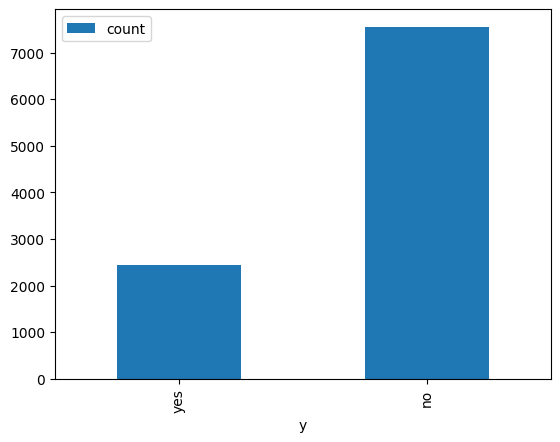

In [ ]:
df.plot.bar()

# 学習の前処理

In [100]:
train_test_data = pd.read_csv('../train_test_2023.csv', encoding='ISO-8859-1')
submit_data = pd.read_csv('../submit_2023.csv', encoding='ISO-8859-1')
# 提出用にsubmit_dataをコピー
submit_data_copy = submit_data.copy()

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 量的変数（連続変数）と質的変数（カテゴリカル変数）の特定（'education-num'は除外する）
quantitative_vars = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
qualitative_vars = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']

# 前処理のための変換器を設定
preprocessor = ColumnTransformer(
    transformers=[
        ('quant', StandardScaler(), quantitative_vars),
        ('qual', OneHotEncoder(), qualitative_vars)
    ])

# 前処理パイプラインの作成
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [102]:
from sklearn.model_selection import train_test_split

# データセットを訓練データとテストデータに分割
train_data, test_data = train_test_split(train_test_data, test_size=0.2, random_state=42)
# 目的変数と説明変数に分割
train_y = train_data['y'].map({'yes': 1, 'no': 0})
train_data = train_data.drop('y', axis=1)
test_y = test_data['y'].map({'yes': 1, 'no': 0})
test_data = test_data.drop('y', axis=1)

# 前処理パイプラインを訓練データにのみ適用し、その後テストデータを変換
preprocessing_pipeline.fit(train_data)
processed_train_data = preprocessing_pipeline.transform(train_data)
processed_test_data = preprocessing_pipeline.transform(test_data)
submit_data = preprocessing_pipeline.transform(submit_data)

# One-hot Encoding後の新しい列名を生成
new_qualitative_column_names = generate_new_column_names(preprocessor, qualitative_vars)
# 最終的な列名のリストを作成（量的変数の名前 + 新しい質的変数の名前）
final_column_names = quantitative_vars + new_qualitative_column_names

# 訓練データとテストデータの前処理後のDataFrameを作成
processed_train_data_df = pd.DataFrame(processed_train_data.toarray(), columns=final_column_names)
processed_test_data_df = pd.DataFrame(processed_test_data.toarray(), columns=final_column_names)
processed_submit_data_df = pd.DataFrame(submit_data.toarray(), columns=final_column_names)

# 訓練データとテストデータの最初の数行を表示
processed_train_data_df


,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,1.432298,0.139188,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.685838,-0.101388,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.732436,0.225685,0.143942,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.180311,0.870742,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.760484,-0.208102,-0.146664,-0.216378,-0.080380,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-1.105666,-0.722608,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7996,2.328049,-0.740048,-0.146664,-0.216378,-1.582223,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7997,-1.254957,-0.067873,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7998,0.611192,-0.117200,-0.146664,4.560129,0.086492,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [103]:
X_train = processed_train_data_df
y_train = train_y
X_test = processed_test_data_df
y_test = test_y

# 学習

## ロジスティック回帰

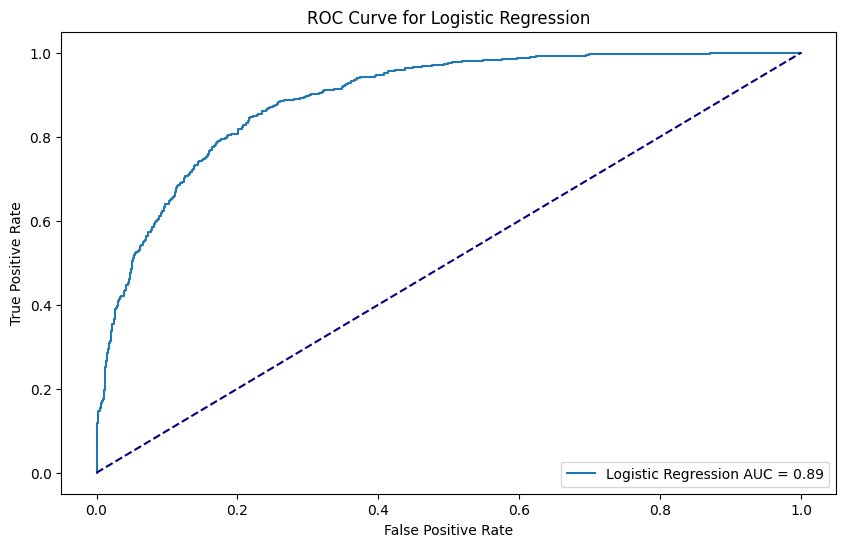

Logistic Regression AUC = 0.8911408693170881


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ロジスティック回帰モデルの初期化と訓練
logistic_model = LogisticRegression(max_iter=2000, random_state=42)
logistic_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
auc_logistic = roc_auc_score(y_test, y_pred_proba_logistic)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression AUC = {auc_logistic:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

print(f'Logistic Regression AUC = {auc_logistic}')

recall = 0.71
precision = 0.65
F1 score = 0.68
Best threshold: 0.37683768376837684
Best F score: 0.7811200706688155
AUC score: 0.8911408693170881


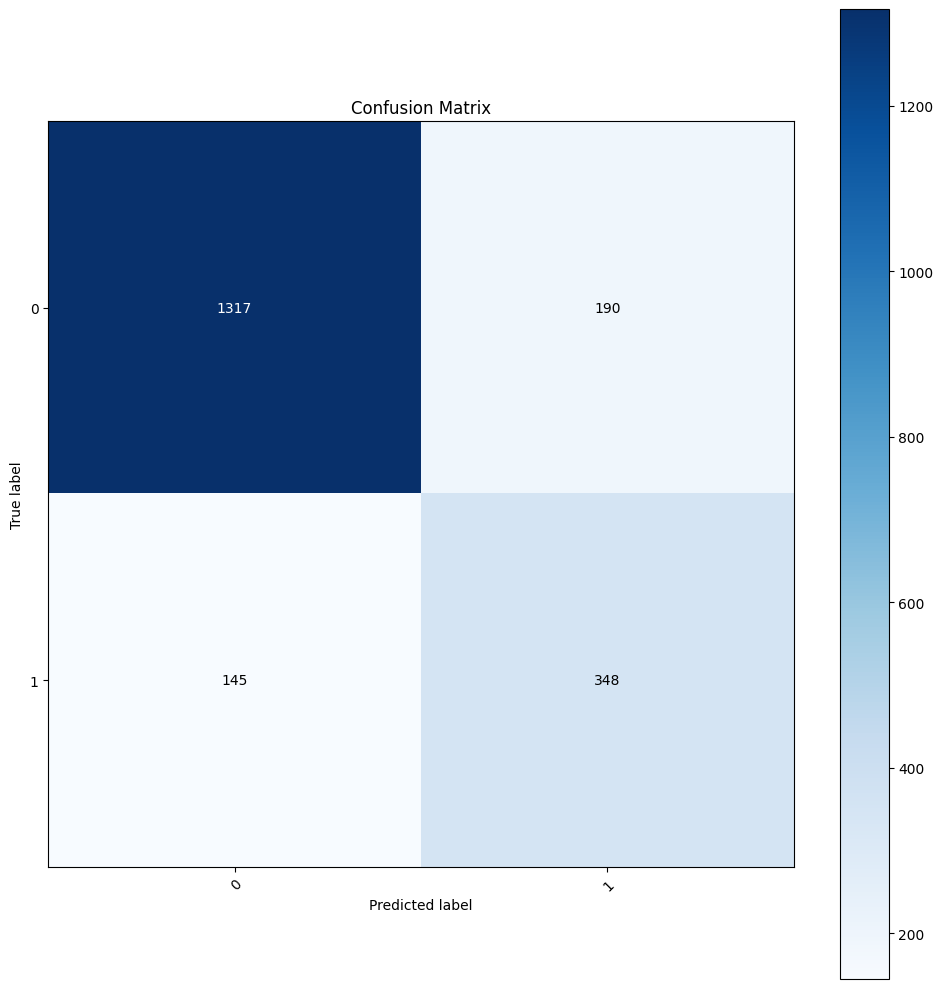

In [105]:
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
ax, best_threshold = plot_confusion_matrix(y_test, y_pred_proba, classes=np.array(['0', '1']), normalize=False, title='Confusion Matrix')
print(f'Best threshold: {best_threshold}')
# その時のf1スコアを計算
print(f'Best F score: {f1_score(y_test, y_pred_proba > best_threshold, average="macro")}')
# その時のAUCスコアを計算
print(f'AUC score: {roc_auc_score(y_test, y_pred_proba)}')

## 決定木

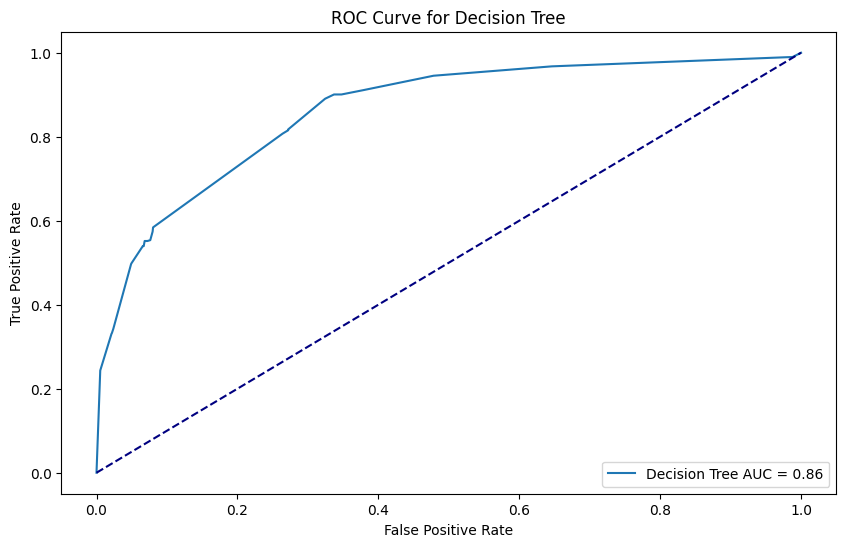

Decision Tree AUC = 0.860887191752888


In [122]:
from sklearn.tree import DecisionTreeClassifier

# 分類木モデルの初期化と訓練
tree_model = DecisionTreeClassifier(random_state=42, max_depth=7)
tree_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)
auc_tree = roc_auc_score(y_test, y_pred_proba_tree)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree AUC = {auc_tree:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

print(f'Decision Tree AUC = {auc_tree}')

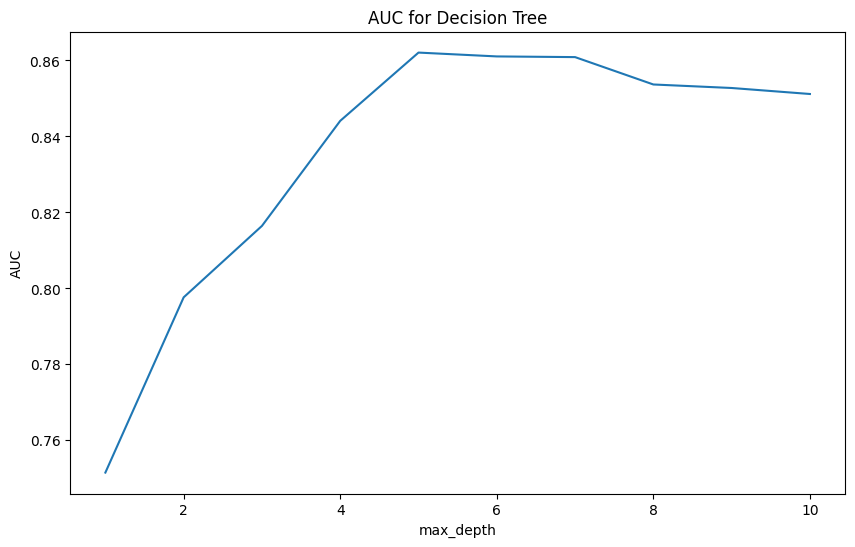

In [107]:
# max_depthを変化させて、AUCをプロット
auc_list = []
for i in range(1, 11):
    tree_model = DecisionTreeClassifier(random_state=42, max_depth=i)
    tree_model.fit(X_train, y_train)
    y_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba_tree)
    auc_list.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), auc_list)
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.title('AUC for Decision Tree')
plt.show()


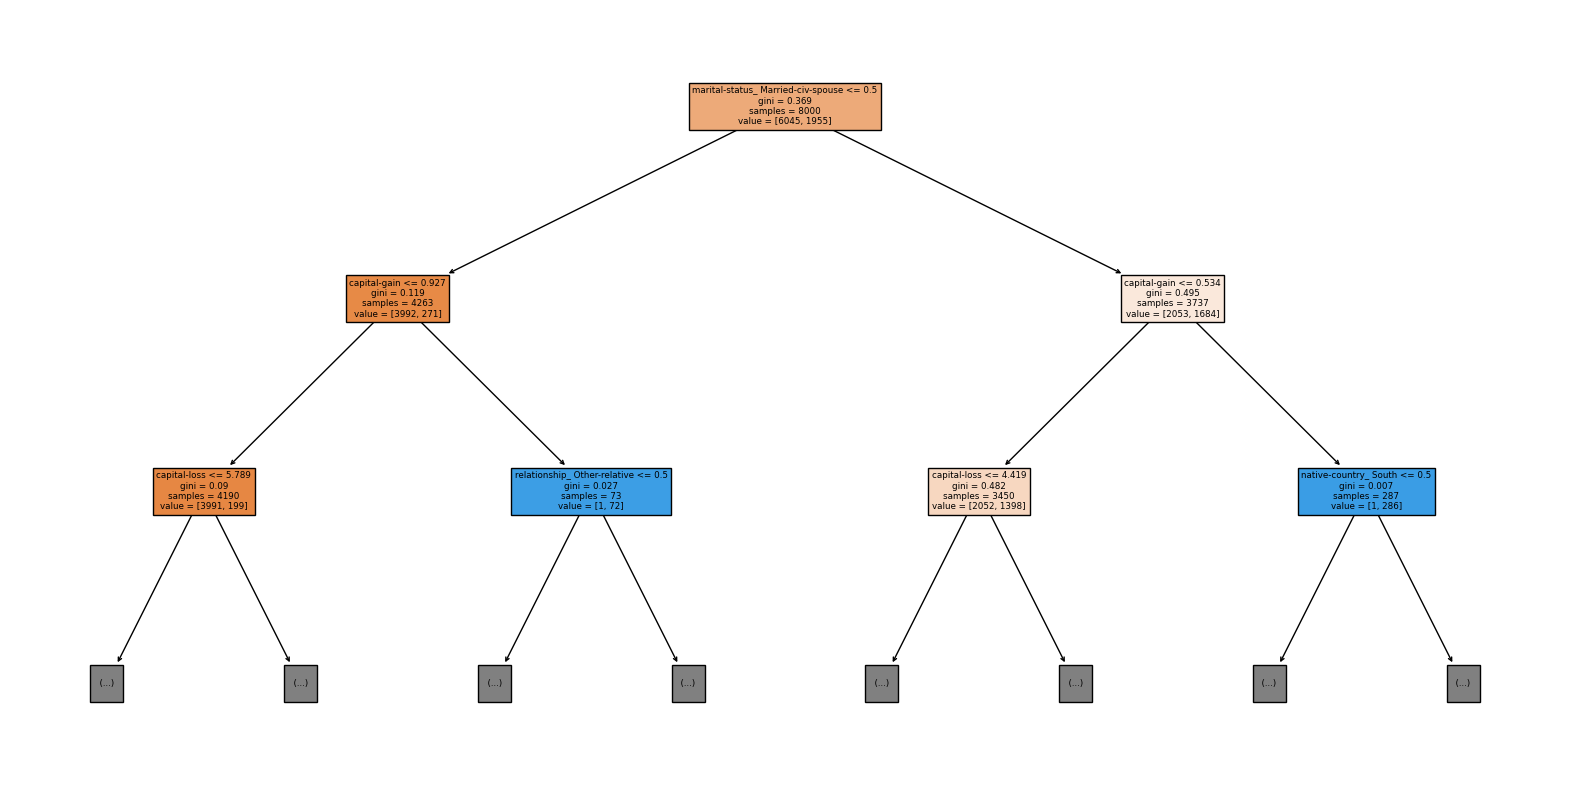

In [123]:
# 決定木の可視化
from sklearn.tree import plot_tree

# 決定木の表示
# みやすくするために、深さは3までを表示
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X_train.columns, filled=True, max_depth=2)
plt.show()
# plt.figure(figsize=(20, 10))
# plot_tree(tree_model, feature_names=X_train.columns, filled=True)
# plt.show()


recall = 0.58
precision = 0.70
F1 score = 0.64
Best threshold: 0.30383038303830384
Best F score: 0.766675875573827
AUC score: 0.860887191752888


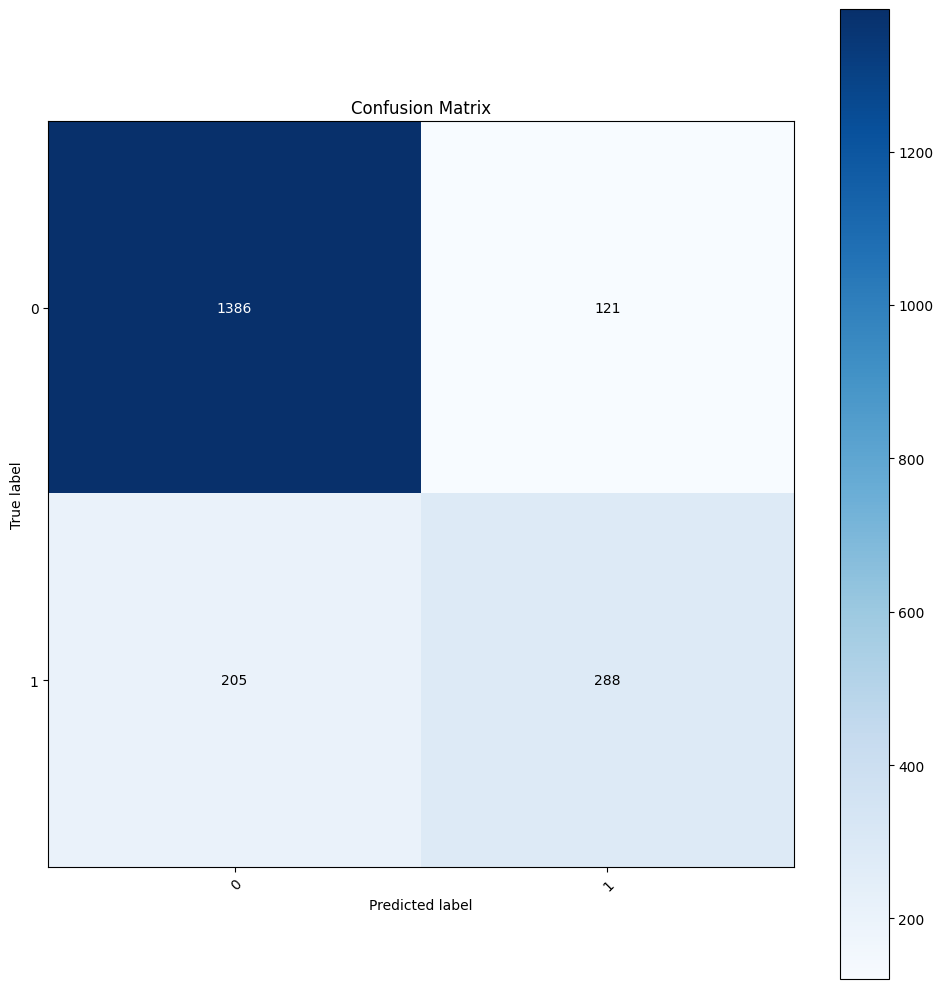

In [124]:
y_pred_proba = tree_model.predict_proba(X_test)[:, 1]
ax, best_threshold = plot_confusion_matrix(y_test, y_pred_proba, classes=np.array(['0', '1']), normalize=False, title='Confusion Matrix')
print(f'Best threshold: {best_threshold}')
# その時のf1スコアを計算
print(f'Best F score: {f1_score(y_test, y_pred_proba > best_threshold, average="macro")}')
# その時のAUCスコアを計算
print(f'AUC score: {roc_auc_score(y_test, y_pred_proba)}')

## LightGBM

### optuna最適化バージョン

[I 2024-01-15 13:20:36,336] A new study created in memory with name: no-name-01663485-144c-419a-9de8-61f620af7b75
[I 2024-01-15 13:20:36,458] Trial 0 finished with value: 0.8954843589954116 and parameters: {'n_estimators': 28, 'learning_rate': 0.08335744671429977, 'max_depth': 7}. Best is trial 0 with value: 0.8954843589954116.
[I 2024-01-15 13:20:36,509] Trial 1 finished with value: 0.8950098997107481 and parameters: {'n_estimators': 50, 'learning_rate': 0.13984916514612825, 'max_depth': 3}. Best is trial 0 with value: 0.8954843589954116.
[I 2024-01-15 13:20:36,678] Trial 2 finished with value: 0.899620567170648 and parameters: {'n_estimators': 245, 'learning_rate': 0.23187723411012573, 'max_depth': 3}. Best is trial 2 with value: 0.899620567170648.
[I 2024-01-15 13:20:36,913] Trial 3 finished with value: 0.9017007851123424 and parameters: {'n_estimators': 215, 'learning_rate': 0.1275871044344882, 'max_depth': 4}. Best is trial 3 with value: 0.9017007851123424.
[I 2024-01-15 13:20:37,

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1955, number of negative: 6045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244375 -> initscore=-1.128841
[LightGBM] [Info] Start training from score -1.128841
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_l

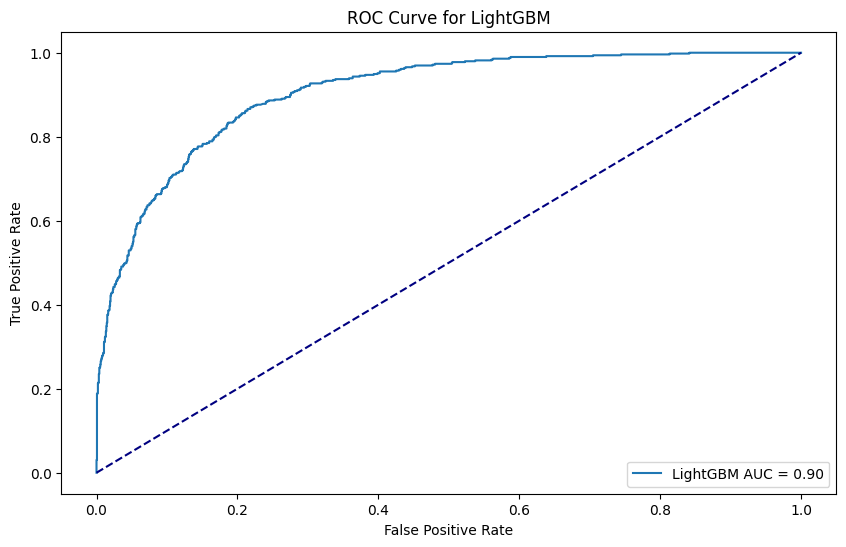

LightGBM AUC = 0.9047144428098219
最適なパラメータ: {'n_estimators': 109, 'learning_rate': 0.05701952600577752, 'max_depth': 9}


In [110]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def objective(trial):
    # チューニングするパラメータの範囲を指定
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 25, 350),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 9)
    }

    # モデルの訓練
    lgb_model = lgb.LGBMClassifier(**param, verbose=-1)
    lgb_model.fit(X_train, y_train)

    # テストデータでの予測とAUCスコアの計算
    y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba_lgb)

    return auc

# Optunaのスタディを作成し、最適化を実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)



# 最適なパラメータでモデルを再訓練
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

# テストデータでの予測を計算
y_pred_proba_lgb = best_model.predict_proba(X_test)[:, 1]


# ROC曲線とAUCスコアを計算
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

# AUCスコアの表示
print(f"AUCスコア: {auc_lgb}")


# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM AUC = {auc_lgb:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc='lower right')
plt.show()

print(f'LightGBM AUC = {auc_lgb}')
# 最適なパラメータの表示
print(f"最適なパラメータ: {study.best_params}")


### optuna使わないバージョン

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1955, number of negative: 6045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244375 -> initscore=-1.128841
[LightGBM] [Info] Start training from score -1.128841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


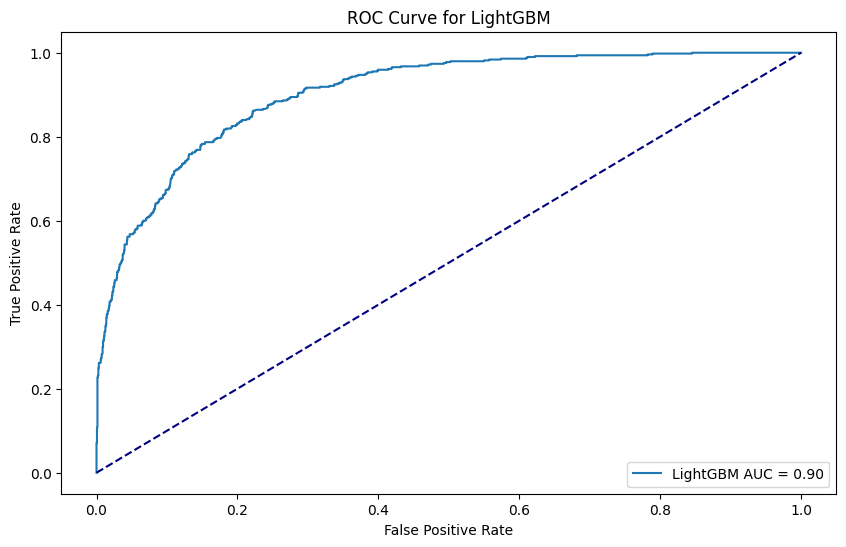

LightGBM AUC = 0.903332117461313


In [111]:
# lightGBMモデルの初期化と訓練
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=169, learning_rate=0.28206, max_depth=2)
lgb_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

# ROC曲線をプロット 
plt.figure(figsize=(10, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM AUC = {auc_lgb:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc='lower right')
plt.show()

print(f'LightGBM AUC = {auc_lgb}')


## XGBoost

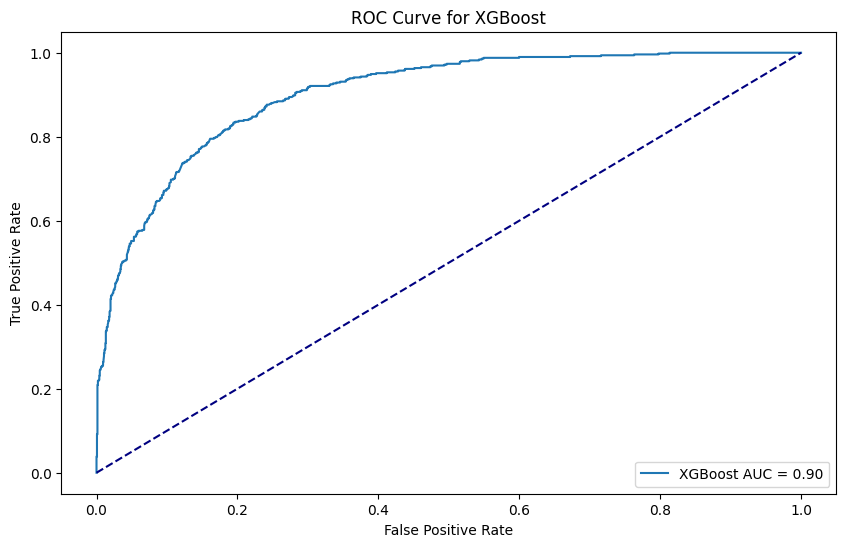

XGBoost AUC = 0.9012801651791302


In [112]:
# XGBoostモデルの初期化と訓練
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, max_depth=2)
xgb_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

print(f'XGBoost AUC = {auc_xgb}')


## CatBoost

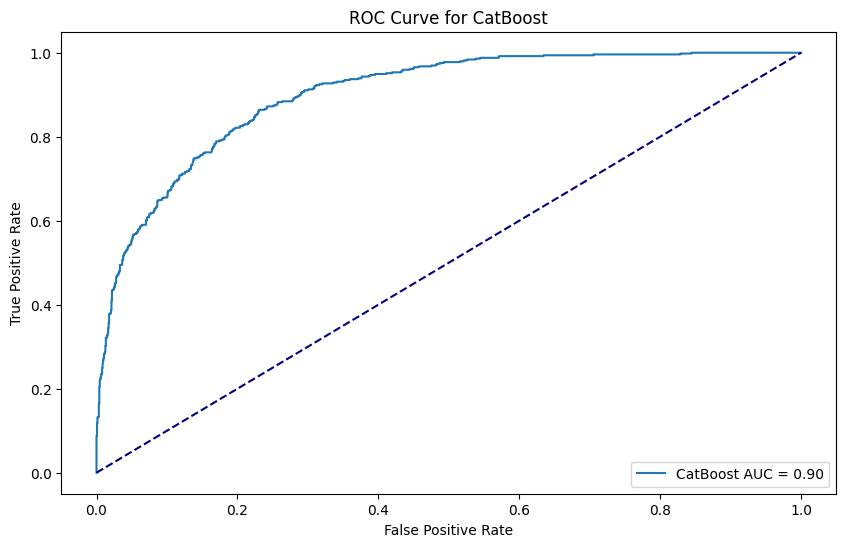

CatBoost AUC = 0.8993850200080491


In [113]:
# catboostモデルの初期化と訓練
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=42, max_depth=2, verbose=False)
catboost_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_pred_proba_catboost)
auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost AUC = {auc_catboost:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost')
plt.legend(loc='lower right')
plt.show()

print(f'CatBoost AUC = {auc_catboost}')

## Random Forest

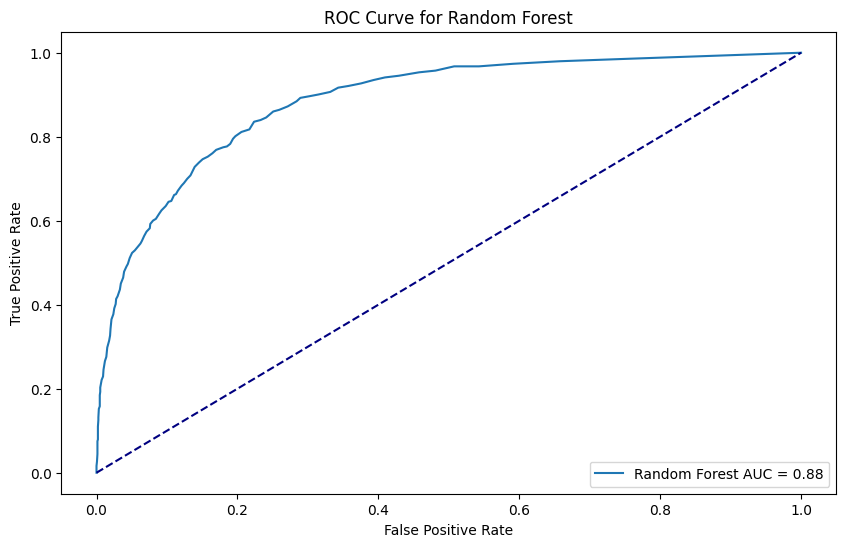

Random Forest AUC = 0.8845415108129606


In [114]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストモデルの初期化と訓練
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ROC曲線とAUCスコアを計算
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

print(f'Random Forest AUC = {auc_rf}')


# アンサンブル

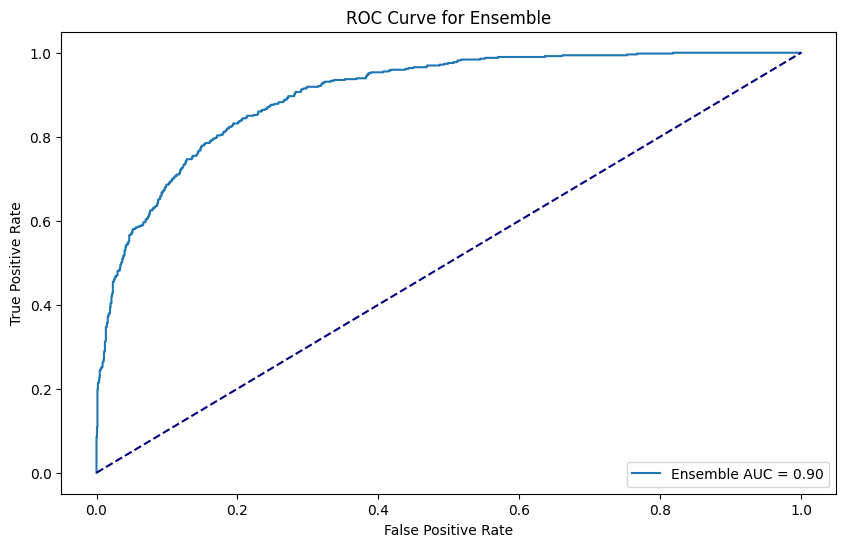

Ensemble AUC = 0.9029969674985295


In [115]:
# 色々なモデルをアンサンブル
# テストデータでの予測確率を計算
# y_pred_proba = (y_pred_proba_logistic + y_pred_proba_tree + y_pred_proba_lgb + y_pred_proba_xgb + y_pred_proba_catboost + y_pred_proba_rf) / 6
y_pred_proba = (y_pred_proba_lgb + y_pred_proba_xgb + y_pred_proba_catboost) / 3
# y_pred_proba = (y_pred_proba_logistic + y_pred_proba_lgb + y_pred_proba_xgb) / 4
# y_pred_proba = (y_pred_proba_logistic + y_pred_proba_tree + y_pred_proba_lgb) / 3
# y_pred_proba = (y_pred_proba_logistic + y_pred_proba_tree) / 2
# y_pred_proba = y_pred_proba_logistic

# ROC曲線とAUCスコアを計算
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# ROC曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Ensemble AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble')
plt.legend(loc='lower right')
plt.show()

print(f'Ensemble AUC = {auc}')


# スタッキング

In [116]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# ベースモデルの例
base_models = [
    # ('lr', LogisticRegression()),
    # ('dt', DecisionTreeClassifier()),
    # ('rf', RandomForestClassifier()),
    # ('svc', SVC(probability=True)),
    ('lgb', lgb.LGBMClassifier()),
    ('xgb', XGBClassifier()),
    ('catboost', CatBoostClassifier(silent=True))
]

# メタモデル
meta_model = LogisticRegression()

# スタッキングモデルの初期化
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# データを訓練セットとテストセットに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# スタッキングモデルの訓練
stacking_model.fit(X_train, y_train)

# テストデータでの予測確率を計算
y_pred_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]

# AUCスコアを計算
auc_stacking = roc_auc_score(y_test, y_pred_proba_stacking)

print(f'Stacking AUC: {auc_stacking}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1955, number of negative: 6045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244375 -> initscore=-1.128841
[LightGBM] [Info] Start training from score -1.128841
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1564, number of negative: 4836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

# F1スコア最適化

In [117]:
from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred_proba, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    混同行列をプロットする関数
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # F1スコアが最も高い閾値を見つける
    thresholds = np.linspace(0, 1, 10000)
    f1_scores = [f1_score(y_true, y_pred_proba > thr, average='macro') for thr in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]

    # 混同行列を計算
    y_pred = (y_pred_proba > best_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    # クラス名を表示
    if classes is not None:
        classes = classes[unique_labels(y_true, y_pred)]
    else:
        classes = unique_labels(y_true, y_pred)

    # 正規化オプションがある場合は、混同行列を正規化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 混同行列をプロット
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # グラフに表示するラベルを設定
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # グラフのフォーマットを設定
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # ヒートマップに数値を表示
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    # recallを計算
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    print(f'recall = {recall:.2f}')
    # precisionを計算
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    print(f'precision = {precision:.2f}')
    # F1スコアを計算
    f1 = 2 * recall * precision / (recall + precision)
    print(f'F1 score = {f1:.2f}')
    return ax, best_threshold

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
recall = 0.70
precision = 0.69
F1 score = 0.70
Best threshold: 0.39223922392239224
Best F score: 0.7973227200896329
AUC score: 0.9047144428098219


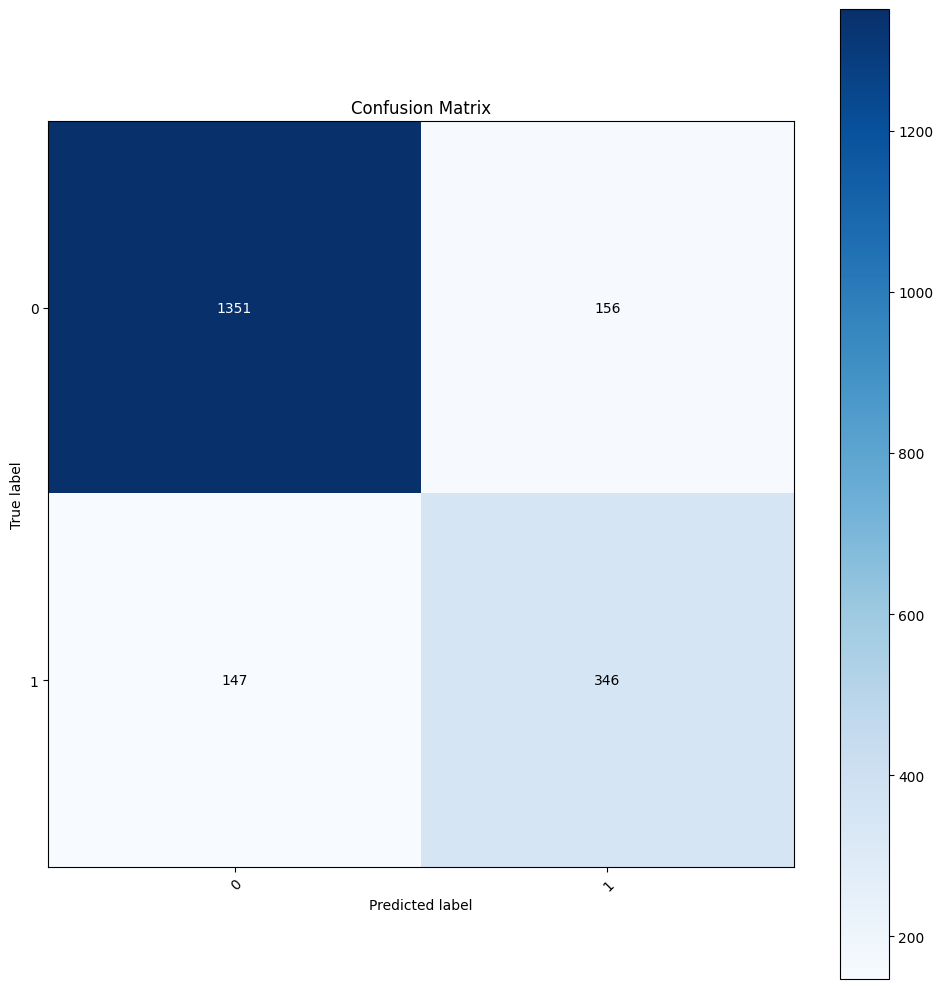

In [125]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
ax, best_threshold = plot_confusion_matrix(y_test, y_pred_proba, classes=np.array(['0', '1']), normalize=False, title='Confusion Matrix')
print(f'Best threshold: {best_threshold}')
# その時のf1スコアを計算
print(f'Best F score: {f1_score(y_test, y_pred_proba > best_threshold, average="macro")}')
# その時のAUCスコアを計算
print(f'AUC score: {roc_auc_score(y_test, y_pred_proba)}')

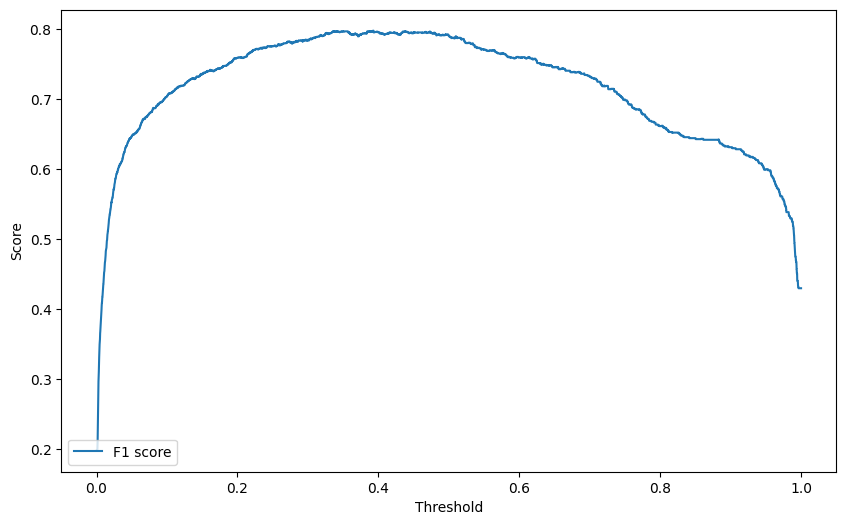

AUC score: 0.90
Best threshold for F1: 0.39223922392239224
Best F1 score: 0.7973227200896329


In [119]:
# F1スコアを閾値に対して計算
thresholds = np.linspace(0, 1, 10000)
f1_scores = [f1_score(y_test, y_pred_proba > thr, average='macro') for thr in thresholds]

# F1スコアをプロット
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='lower left')
plt.show()

# AUCスコアは閾値に依存しないため、一度だけ計算する
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC score: {auc_score:.2f}')

# F1スコアに関して最適な閾値を出力
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
print(f'Best threshold for F1: {best_threshold_f1}')
print(f'Best F1 score: {f1_score(y_test, y_pred_proba > best_threshold_f1, average="macro")}')


# 特徴量重要度をプロット

<Figure size 1000x600 with 0 Axes>

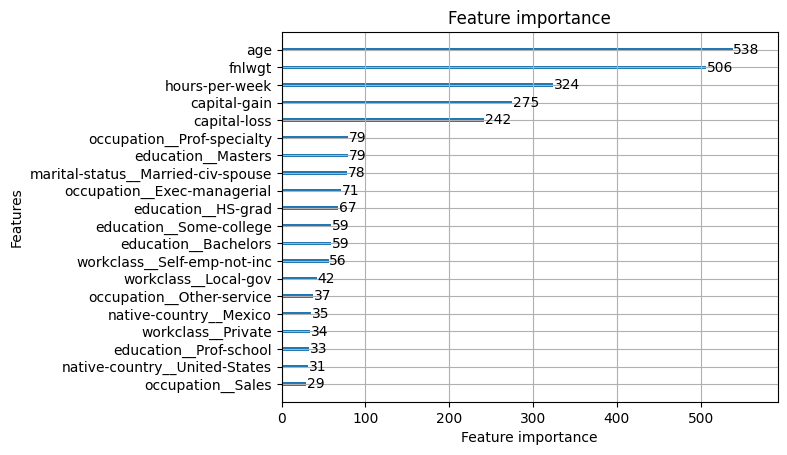

In [120]:
# LightGBMでの特徴量の重要度をプロット
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_model, max_num_features=20)
plt.title('Feature importance')
plt.show()


# submit_data

In [121]:
processed_submit_data_df

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,-0.135268,-0.266790,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.536546,-0.578321,-0.146664,-0.216378,0.003056,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.387254,-1.069440,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.611192,-1.477727,-0.146664,-0.216378,1.588335,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.433852,0.106029,-0.146664,-0.216378,-0.497559,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.433852,-0.308262,-0.146664,-0.216378,0.753977,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
996,-0.583144,0.528109,-0.146664,-0.216378,-0.914737,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,-0.060622,2.101429,-0.146664,-0.216378,-0.080380,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
998,-1.031020,1.080047,-0.146664,4.560129,-0.080380,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
X_submit= processed_submit_data_df

In [127]:
# submit_dataでの予測確率を計算
y_pred_proba_submit = best_model.predict_proba(X_submit)[:, 1]
submit_data_copy['probability of yes (or score)'] = y_pred_proba_submit
# submit_data_copy['y (yes or no)  '] = (y_pred_proba_submit > 0.5).astype(int)
submit_data_copy['y (yes or no)  '] = (y_pred_proba_submit > best_threshold).astype(int)
submit_data_copy['y (yes or no)  '] = submit_data_copy['y (yes or no)  '].map({1: 'yes', 0: 'no'})

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [128]:
submit_data_copy['y (yes or no)  '].value_counts()

y (yes or no)  
no     741
yes    259
Name: count, dtype: int64

In [129]:
submit_data_copy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y (yes or no),probability of yes (or score)
0,37,Private,162322,Assoc-voc,11,Separated,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,no,0.032152
1,46,Private,129007,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,41,United-States,no,0.355241
2,44,Private,76487,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,no,0.260233
3,47,Private,32825,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,yes,0.437975
4,33,Private,202191,Some-college,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,no,0.008250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,Private,157887,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,50,United-States,no,0.274075
996,31,Private,247328,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,30,El-Salvador,no,0.005801
997,38,Private,415578,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,no,0.179979
998,25,Local-gov,306352,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,40,Mexico,yes,0.801760


In [130]:
# 提出用ファイルを作成
submit_data_copy.to_csv('submit_2023.csv', index=False)